In [1]:
%matplotlib inline
import pylab as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# Projections

In Astronomy or in Cartography, one often needs to map a sphere onto a plane. Mapping from a non-Euclidean surface to a Euclidean surface is non-trivial if you want to preserve all the details. Below are some properties based on which you can choose what projection is best for your science purposes. 

1. **Conformal**: These projections preserve angles locally. They are good for representing structures to the eye faithfully - eg. shapes of the continents on Earth. Conformal projections often distort the area to acheive this. Some useful conformal projections are *Sterographic* and the *Mercator* Projection.<br/><br/>

2. **Equal Area**: For statistical purposes, it is more useful to have projections that preserve area- eg. population per sq. mile in a country. Such projections severly suffer from distortions to the shape at wide angles. For example, *Mollweide*, *Hammer-Aitoff* and *Sinusoidal* projections.<br/><br/>

3. **Gnomonic**: Projections in which great circles are straight lines. Only half the sphere can be represented in such a projection. Example- *Gnomonic* projection. <br/><br/>

4. **Equidistant**: Distances from a single point on the map are all on the same scale. For example- *Cylindrical equidistant* and *Azimuthal equidistant* projection.<br/><br/>

5. **Perspective**: The view you would get by placing your eye at one position. For example- if your eye was at infinity you would see the globe. This particular projection is called an *Orthographic* projection.

See https://www.youtube.com/watch?v=eLqC3FNNOaI for fun.

# Using Basemap to Create a Projection

The job of a projection is to create a mapping between an image coordinate (i.e.
pixels) and a latitude/longitude in your spherical coordinate system.  The Basemap
object provides you this functionality.  You can explicitly ask for an image grid, and
it will tell you the longitude and latitude of each pixel coordinate, as shown below.

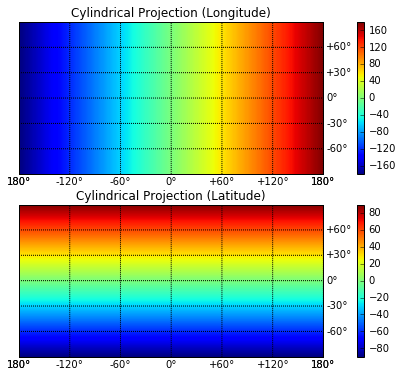

In [2]:
m = Basemap(projection='cyl') # Cylindrical projection
lons,lats = m.makegrid(1000,500) # 1000 lons by 500 lats

plt.figure(figsize=(12,6))
plt.subplot(211)

plt.title('Cylindrical Projection (Longitude)')
m.imshow(lons)
m.drawmeridians(np.arange(-180, 180, 60), labels=[0,0,0,1], labelstyle='+/-')
m.drawparallels(np.arange(-90,90,30)[1:], labels=[0,1,0,0], labelstyle='+/-')
plt.colorbar()

plt.subplot(212)
plt.title('Cylindrical Projection (Latitude)')
m.imshow(lats)
m.drawmeridians(np.arange(-180, 180, 60), labels=[0,0,0,1], labelstyle='+/-')
m.drawparallels(np.arange(-90,90,30)[1:], labels=[0,1,0,0], labelstyle='+/-')
plt.colorbar()
plt.show()

You can try other projections (e.g. Mollweide, below).  Some projections have image pixels that
do not map to the sphere at all.  These may need to be manually masked to avoid distracting features.
One thing in particular to be aware of is that the values in these blank pixels can mess up the
automatic scaling that imshow does.  If you find that you image looks uniformly dark, try manually
setting vmax and vmin.

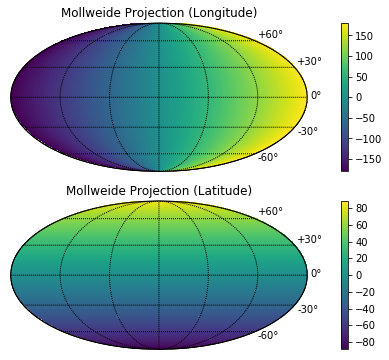

In [73]:
m = Basemap(projection='moll', lon_0=0) # Mollweide projection
lons,lats,x,y = m.makegrid(1000,500,returnxy=True) # 1000 lons by 500 lats

# Mask off parts of the image to be plotted that are outside of the map
lt = lats[:,0]
ln1 = np.ones_like(lt) * (lons[lons.shape[0]/2,0])
ln2 = np.ones_like(lt) * (lons[lons.shape[0]/2,-1])
x1,y1 = m(ln1,lt); x2,y2 = m(ln2,lt)
x = np.ma.array(x)
for c,(i,j) in enumerate(zip(x1,x2)): x[c] = np.ma.masked_outside(x[c], i, j)
mask = x.mask

plt.figure(figsize=(12,6))
plt.subplot(211)
plt.title('Mollweide Projection (Longitude)')
m.imshow(np.ma.array(lons,mask=mask))
m.drawmapboundary()
m.drawmeridians(np.arange(-180, 180, 60))
m.drawparallels(np.arange(-90,90,30)[1:], labels=[0,1,0,0], labelstyle='+/-')
plt.colorbar()
plt.subplot(212)
plt.title('Mollweide Projection (Latitude)')
m.imshow(np.ma.array(lats,mask=mask))
m.drawmapboundary()
m.drawmeridians(np.arange(-180, 180, 60))
m.drawparallels(np.arange(-90,90,30)[1:], labels=[0,1,0,0], labelstyle='+/-')
plt.colorbar()
plt.show()

Some projections require you to provide the center point of the projection.  For example, orthographic projections
need both a lat_0 and a lon_0 to center at.  

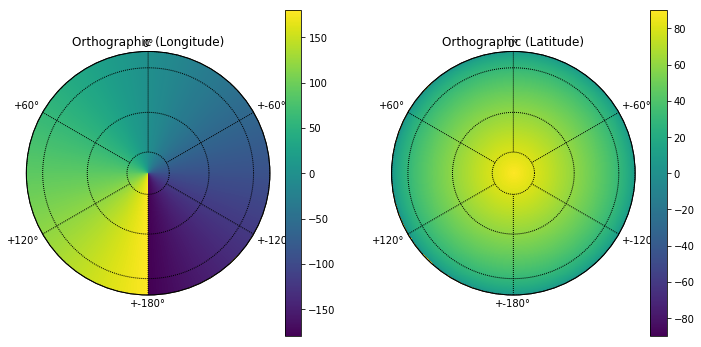

In [74]:
m = Basemap(projection='ortho',lat_0=90,lon_0=180,rsphere=1.)
lons,lats = m.makegrid(500,500) # 500 lons by 500 lats

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Orthographic (Longitude)')
m.imshow(lons, vmin=-180, vmax=180)
m.drawmapboundary()
m.drawmeridians(np.arange(-180, 180, 60), labels=[1,1,1,1], labelstyle='+/-')
m.drawparallels(np.arange(-90,90,30)[1:])
plt.colorbar()
plt.subplot(122)
plt.title('Orthographic (Latitude)')
m.imshow(lats, vmax=-90, vmin=90)
m.drawmapboundary()
m.drawmeridians(np.arange(-180, 180, 60), labels=[1,1,1,1], labelstyle='+/-')
m.drawparallels(np.arange(-90,90,30)[1:])
plt.colorbar()
plt.show()

Basemap has a lot of other things it can do.  Some is very useful.  Some is irrelevant for astronomy.

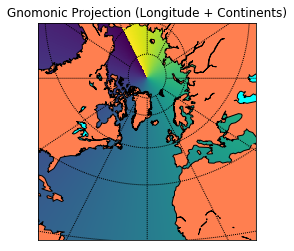

In [75]:
import warnings
warnings.filterwarnings("ignore")
m = Basemap(width=15e6,height=15e6,projection='gnom',lat_0=60.,lon_0=-30.)
lons,lats = m.makegrid(1000,500)
m.imshow(lons)
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawparallels(np.arange(10,90,20))
m.drawmeridians(np.arange(-180,180,30))
plt.title('Gnomonic Projection (Longitude + Continents)')
plt.show()

# Working with a Spherical Data Set

In this section, we will work with a spherical dataset, the Haslam 408 MHz survey.  Healpix is a method for representing spherical datasets with a series of $12N^2$ pixels.  Each pixel contains equal area, but not all pixels have the same shape.  One of the most powerful aspects of Healpix is its support for looking up the pixels nearest a requested coordinate and interpolating the nearest pixels to estimate a value at that coordinate.

Using this functionality (which is wrapped into Python in the AIPY package), we can request the map value at each $(\theta,\phi)$ given the lat/lon in each pixel coordinate, thereby creating a projection of the spherical data set onto a 2D array.  The only trick is recognizing the difference between $\theta$ (measured from the pole) and latitude (measured from the equator).

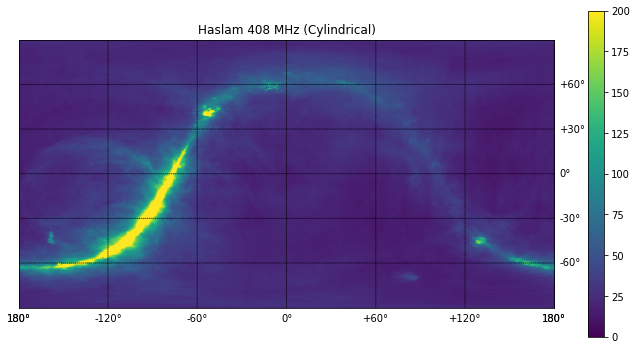

In [79]:
from aipy.healpix import HealpixMap
h = HealpixMap(fromfits='lambda_haslam408_dsds_eq.fits')
m = Basemap(projection='cyl') # Cylindrical projection
lons,lats = m.makegrid(1000,500) # 1000 lons by 500 lats

phi, theta = lons*np.pi/180, np.pi/2 - lats*np.pi/180
data = h[theta.flatten(),phi.flatten()]
data.shape = lons.shape

plt.figure(figsize=(12,6))
plt.title('Haslam 408 MHz (Cylindrical)')
m.imshow(data, vmax=200, vmin=0)
m.drawmeridians(np.arange(-180, 180, 60), labels=[0,0,0,1], labelstyle='+/-')
m.drawparallels(np.arange(-90,90,30)[1:], labels=[0,1,0,0], labelstyle='+/-')
plt.colorbar()
plt.show()

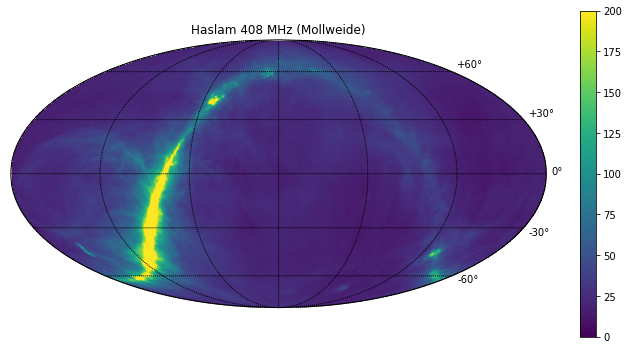

In [80]:
m = Basemap(projection='moll', lon_0=0) # Mollweide projection
lons,lats,x,y = m.makegrid(1000,500,returnxy=True) # 1000 lons by 500 lats

# Mask off parts of the image to be plotted that are outside of the map
lt = lats[:,0]
ln1 = np.ones_like(lt) * (lons[lons.shape[0]/2,0])
ln2 = np.ones_like(lt) * (lons[lons.shape[0]/2,-1])
x1,y1 = m(ln1,lt); x2,y2 = m(ln2,lt)
x = np.ma.array(x)
for c,(i,j) in enumerate(zip(x1,x2)): x[c] = np.ma.masked_outside(x[c], i, j)
mask = x.mask

phi, theta = lons*np.pi/180, np.pi/2 - lats*np.pi/180
data = h[theta.flatten(), phi.flatten()]
data.shape = lons.shape
data = np.ma.array(data, mask=mask)

plt.figure(figsize=(12,6))
plt.title('Haslam 408 MHz (Mollweide)')
m.imshow(data, vmax=200, vmin=0)
m.drawmeridians(np.arange(-180, 180, 60))
m.drawparallels(np.arange(-90,90,30)[1:], labels=[0,1,0,0], labelstyle='+/-')
plt.colorbar()
plt.show()

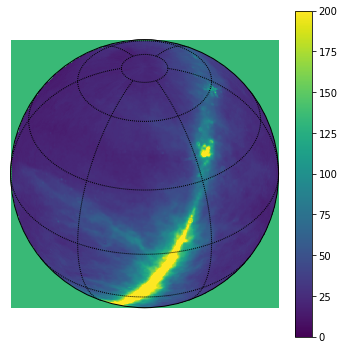

In [81]:
m = Basemap(projection='ortho',lat_0=37,lon_0=270,rsphere=1.)
lons,lats = m.makegrid(500,500) # 500 lons by 500 lats
phi, theta = lons*np.pi/180, np.pi/2 - lats*np.pi/180
data = h[theta.flatten(), phi.flatten()]
data.shape = lons.shape

plt.figure(figsize=(6,6))
m.imshow(data, vmin=0, vmax=200)
m.drawmapboundary()
m.drawmeridians(np.arange(-180, 180, 60))
m.drawparallels(np.arange(-90,90,30)[1:])
plt.colorbar()